<a href="https://colab.research.google.com/github/nrjcs/iitpbse/blob/master/Jyoti_Autoencoder_anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data1.csv to data1.csv


In [ ]:
import pandas as pd
#https://pandas.pydata.org/docs/reference/index.html

import numpy as np
#https://numpy.org/doc/stable/user/tutorials_index.html

from matplotlib import pyplot as plt
#https://matplotlib.org/tutorials/index.html

from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
#https://scikit-learn.org/stable/user_guide.html

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
#https://keras.io/api/

import seaborn as sns
#https://seaborn.pydata.org/api.html

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Anomaly detection using autoencoder**

In [ ]:
df = pd.read_csv("data1.csv")

In [ ]:
data2= df.drop(['timestamp','time_epoch'], axis=1)

In [ ]:
print(data2[7030:7040])

          value  hours  daylight  DayOfTheWeek  WeekDay  categories  anomaly
7030  15.077814     19         1             6        0           1        0
7031  15.186548     20         1             6        0           1        0
7032  14.724430     21         1             6        0           1        1
7033  15.059782     22         1             6        0           1        1
7034  14.533523     23         0             6        0           0        1
7035  14.679799      0         0             0        1           2        1
7036  14.367725      1         0             0        1           2        1
7037  14.799608      2         0             0        1           2        0
7038  15.041495      3         0             0        1           2        0
7039  15.828292      4         0             0        1           2        0


# Split the data in to training, test, and validation set.

In [ ]:
df2_train, df2_test = train_test_split(data2, test_size=0.2,random_state=123 )
df2_train, df2_valid = train_test_split(df2_train, test_size=0.2,random_state=123)

# Remove the anomalous instances from training and validation set.

**Basic steps to Anomaly Detection using an Autoencoder:**

 - Train an Autoencoder on normal data (no anomalies)


 - Take a new data point and try to reconstruct it using the Autoencoder

 - If the error (reconstruction error) for the new data point is above some threshold, we label the example as an anomaly.

In [ ]:
train_data21 = df2_train.loc[df2_train['anomaly'] == 0, ['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay','categories','anomaly']]
val_data21 = df2_valid.loc[df2_valid['anomaly'] == 0, ['value', 'hours', 'daylight', 'DayOfTheWeek','WeekDay','categories', 'anomaly']]

**# Drop the label column**

In [ ]:
train_data2= train_data21.drop(['anomaly'], axis=1)
val_data2=val_data21.drop(['anomaly'], axis=1)
test_data2=df2_test.drop(['anomaly'], axis=1)

**# Size of the train, validation and test data set**

In [ ]:
print(train_data2.shape)
print(val_data2.shape)
print(test_data2.shape)

(4608, 6)
(1151, 6)
(1454, 6)


**# parameters**

In [ ]:
batch_size = 64
input_dim = 6 
encoding_dim = 64
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

# Create the autoencoder model 

**Autoencoder :**

 - Autoencoder takes the input and encodes it into a hidden representation. (encoder) \

 - It decodes the input again from this hidden representation. (decoder) \

-   The model is trained to minimize a loss function (MSE) to ensure that Xi is close to X'i 




In [ ]:
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense (Dense)                (None, 64)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
Total params: 6,086
Trainable params: 6,086
Non-trainable params: 0
____________________________________________________

**# Compile and train the model**

In [ ]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(train_data2, train_data2,
                    epochs=20,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(val_data2, val_data2),
                    verbose=1,
                    callbacks=[cp, tb]).history

Epoch 1/20
 1/72 [..............................] - ETA: 0s - loss: 102.4097 - accuracy: 0.9531WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
72/72 [==============================] - 0s 5ms/step - loss: 24.3428 - accuracy: 0.9336 - val_loss: 2.2895 - val_accuracy: 0.9409
Epoch 2/20
72/72 [==============================] - 0s 2ms/step - loss: 0.9867 - accuracy: 0.9835 - val_loss: 0.4473 - val_accuracy: 0.9922
Epoch 3/20
72/72 [==============================] - 0s 2ms/step - loss: 0.2829 - accuracy: 0.9939 - val_loss: 0.2277 - val_accuracy: 0.9922
Epoch 4/20
72/72 [==============================] - 0s 2ms/step - loss: 0.2179 - accuracy: 0.9963 - val_loss: 0.2088 - val_accuracy: 0.9974
Epoch 5/20
72/72 [==============================] - 0s 2ms/step - loss: 0.199

**# training loss vs validation loss**

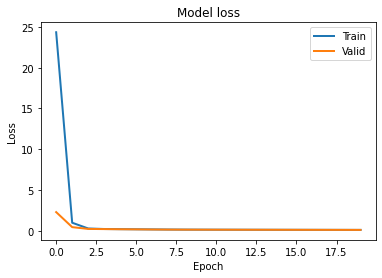

In [ ]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

**# Test the autoencoder model on test dataset**

In [ ]:
test_x_predictions = autoencoder.predict(test_data2)
t=test_data2.values
mse = np.mean(np.power(t - test_x_predictions, 2), axis=1)  
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df2_test['anomaly']})
error_df_test = error_df_test.reset_index()

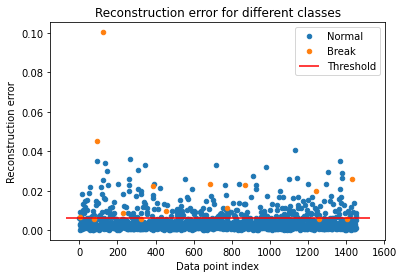

In [ ]:
threshold_fixed = 0.006
groups = error_df_test.groupby('True_class')

fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=4.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

**# Confusion matrix**

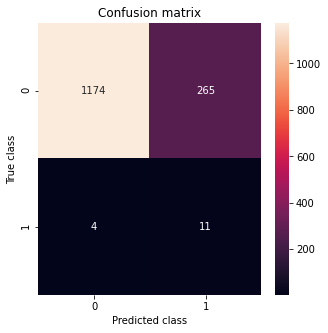

In [ ]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df_test.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_test.True_class, pred_y)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()